# [Spotahome.com](https://www.spotahome.com/s/london--uk/for-rent:apartments/for-rent:studios/bedrooms:1/bedrooms:2/bedrooms:3/bedrooms:3more?areaId[]=219&areaId[]=231&areaId[]=232&areaId[]=233&areaId[]=234&areaId[]=235&areaId[]=236&areaId[]=237&areaId[]=241)

## Dataframe with information from search result page

In [1]:
import requests                 # requests on websites
from bs4 import BeautifulSoup   # html parsing

import pandas as pd             # pandas for data frame
import numpy as np              # numpy for numerical operations

import math                     # for math methods
import time                     # for sleep timer
import random                   # for random number generator

import sql_functions as sf      # for sql functions
from sql_functions import *     # functions from file for upload on schema

import sqlalchemy               # for sql connection
import psycopg2                 # for upload on engine

import datetime as dt           # for the csv file with the current date and time
from datetime import date       # for the csv file with the current date and time
import re                       # for regular expressions

import matplotlib as mpl        # for plotting
import matplotlib.pyplot as plt # for plotting
import seaborn as sns           # for plotting

In [2]:
# Creating a function to get all the descriptions
def get_description(bs):
    # find all the descriptions and save them to an empty list
    lst_name = []
    descriptions = bs.find_all(
        class_='homecard-content__title__HomecardContent___OmV4c homecard-content__title--rebranding-style__HomecardContent___OmV4c')
    # iterate over the descriptions to get the text and strip the strings and save them in a list
    for description in descriptions:
        lst_name.append(
            description.get_text()
                .strip()
        )
    return lst_name


# Creating a function to get all the housing types
def get_housing(bs):
    # find all the housing types and save them to an empty list
    lst_name = []
    housings = bs.find_all(
        class_='homecard-content__type__HomecardContent___OmV4c homecard-content__type--rebranding-style__HomecardContent___OmV4c')
    # iterate over the housing types to get the text and strip the strings and save them in a list
    for housing in housings:
        lst_name.append(
            housing.get_text()
                .strip()
        )
    return lst_name


# Creating a function to get all the available dates
def get_available(bs):
    # find all the available dates and save them to an empty list
    lst_name = []
    availables = bs.find_all(
        class_='homecard-content__available-from__HomecardContent___OmV4c homecard-content__available-from--rebranding-style__HomecardContent___OmV4c')
    # iterate over the available appartements to get the text and strip the string and save them in a list
    for available in availables:
        lst_name.append(
            available.get_text()
                .strip()
                .replace('From ', '')
        )
    return lst_name


# Creating a function to get all the prices
def get_price(bs):
    # find all the prices and save them to an empty list
    lst_name = []
    prices = bs.find_all(class_='price__Price___OmV4c')
    # iterate over the prices to get the text and strip the strings and save them in a list
    for price in prices:
        lst_name.append(
            price.get_text()
                .strip()
                .replace('£', '')

        )
    return lst_name


# Creating a function to get all the prices per period
def get_prices_period(bs):
    # find all the aprices per period and save them to an empty list
    lst_name = []
    prices_period = bs.find_all(
        class_='price-monthly__Price___OmV4c price-monthly--rebranding-style__Price___OmV4c')
    # iterate over the prices per period to get the text and strip the string and save them in a list
    for price_period in prices_period:
        lst_name.append(
            price_period.get_text()
                .strip()
                .replace('/', '')
        )
    return lst_name


# Creating a function to get all the ID's
def get_ids(bs):
    # find all the prices and save them to an empty list
    lst_name = []
    ids = bs.find_all(class_='l-list__item')
    # iterate over the prices to get the text and strip the strings and save them in a list
    for id in ids:
        lst_name.append(
            id.get('data-homecard-scroll')
                .strip()
        )
    return lst_name


# Create dictionary in which every location ID gets assigned a location name
location_dict = {219: 'Lambeth',
                 231: 'Hammersmith and Fulham',
                 232: 'Kensington and Chelsea',
                 233: 'City of Westminster',
                 234: 'Camden',
                 235: 'Tower Hamlets',
                 236: 'Islington',
                 237: 'Hackney',
                 241: 'City of London'
                 }


# Creating a function to get the search result from all pages
# the website spotahome shows 60 search results per page. To iterate trough all the pages, we get the information how many search results are there, then divide it by 60 and round it up to get the number of pages.
def page_results(property_type, location):
    # get the url from the website with the property type and the location as a variable to iterate trough it
    page = requests.get(
        f'https://www.spotahome.com/s/london--uk/for-rent:{property_type}?areaId[]={location}')
    html = page.content
    bs = BeautifulSoup(html, 'html.parser')

    # Extracting the total number of search results
    results = bs.find_all('h1', {'class': 'search-title__title'})

    # define the variable result_text in case the first search gives us no results
    result_text = 0

    # iterate over the results to get the text and strip the string
    for result in results:
        result_text = result.find("strong").get_text().strip()

    # convert the extracted string to an integer to perform mathematical operations
    result_converted = int(result_text)

    # divide the converted result by 60 since one pages shows 60 results and round it up to get the number of pages
    page_site = result_converted / 60
    page_site = math.ceil(page_site)

    # convert the number of pages from a float to an integer to iterate trough the pages
    page_converted = int(page_site)

    # create an empty data frame to store the results from every loop cycle
    df_search = pd.DataFrame()

    # split the url to get access to the part where the page is definde
    begin = f'https://www.spotahome.com/s/london--uk/for-rent:{property_type}'
    end = f'?areaId[]={location}'

    # range is including in the beginning and excluding in the end so we add plus 1 to iterate through all calculated pages
    page_converted = page_converted + 1

    # for loop to get the page numbers
    for page_number in range(page_converted):
        # sleep timer to reduce the traffic for the server
        time.sleep(random.randint(2, 6)/10)

        # get the url from the website with the property type, the location and the page number as a variable to iterate trough it
        # middle =
        page = requests.get(begin+f'/page:{page_number}'+end)
        html = page.content
        bs = BeautifulSoup(html, 'html.parser')

        # Create a dictionary to store the results from every loop cycle.
        # The keys are the column names and the values are the functions we created before.
        # The functions are called with the beautiful soup object as a parameter.
        spotahome_dict = {
            'platform_id': get_ids(bs),
            'platform': 'Spotahome',
            'neighbourhood': location_dict[location],
            'detailed_furniture': 'furnished',
            'property_type': property_type,
            'housing_type': get_housing(bs),
            'price': get_price(bs),
            'available_from': get_available(bs),
            'available_today': '',
            'let_type': '',
            'original_furniture': '',
            'scraping_date': date.today(),
            'title': get_description(bs),
            #'scraping_date': dt.datetime.now().strftime('%Y-%m-%d')

        }
        # the ditionary is stored in a dataframe
        df_page = pd.DataFrame(data=spotahome_dict)

        # the temporary data frame gets appended to the data frame we created earlier outside the for loop
        # for every iteration, the data frame page stores the results in the data frame search
        #df_search = df_search.append(df_page)
        df_search = pd.concat([df_search, df_page], axis=0, ignore_index=True)
    # the data frame search gets returned to the for loop to access it outside the function
    return (df_search)


# creating a list with different property types given from the website
property_types = ['studios', 'apartments/bedrooms:1',
                  'apartments/bedrooms:2', 'apartments/bedrooms:3', 'apartments/bedrooms:3more']
# creating a list with the different location IDs given from the website
locations = [219, 231, 232, 233, 234, 235, 236, 237, 241]

# creating an empty data frame
df_complete_1 = pd.DataFrame()
# for loop to get the different property types
for property_type in property_types:
    # for loop to get the different locations
    for location in locations:
        # append the result from data frame search by calling the function page_results with the property type and the location as a parameter to data frame complete
        df_complete_1 = pd.concat([df_complete_1, page_results(
            property_type, location)], axis=0, ignore_index=True)

df_complete_1 = df_complete_1.join(df_complete_1['price'].str.split(
    '-', expand=True).add_prefix('price_'))
df_complete_1 = df_complete_1.join(df_complete_1['available_from'].str.split(
    ' ', expand=True).add_prefix('available_from_'))


In [3]:
df_complete_1


,platform_id,platform,neighbourhood,detailed_furniture,property_type,housing_type,price,available_from,available_today,let_type,original_furniture,scraping_date,title,price_0,price_1,available_from_0,available_from_1,available_from_2
0,654298,Spotahome,Hammersmith and Fulham,furnished,studios,Studio,2650,16 December,,,,2022-10-11,The Armadale Road Residence II,2650,None,16,December,None
1,654299,Spotahome,Hammersmith and Fulham,furnished,studios,Studio,2500,20 December,,,,2022-10-11,The Armadale Road Residence III,2500,None,20,December,None
2,113567,Spotahome,Hammersmith and Fulham,furnished,studios,Studio,1400,18 June 2023,,,,2022-10-11,Studio flat with double bed to rent in Kensing...,1400,None,18,June,2023
3,761515,Spotahome,Kensington and Chelsea,furnished,studios,Studio,2250,16 October,,,,2022-10-11,Studio for rent in a co-living building in Not...,2250,None,16,October,None
4,607194,Spotahome,Kensington and Chelsea,furnished,studios,Studio,3033,18 October,,,,2022-10-11,"Studio for rent in Earls Court, London",3033,None,18,October,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,844665,Spotahome,Hackney,furnished,apartments/bedrooms:3more,Apartment,8250-10950,8 January 2023,,,,2022-10-11,4-bedroom apartment for rent in London,8250,10950,8,January,2023
830,843245,Spotahome,Hackney,furnished,apartments/bedrooms:3more,Apartment,9000-11250,11 January 2023,,,,2022-10-11,4-bedroom apartment for rent in London,9000,11250,11,January,2023
831,398966,Spotahome,Hackney,furnished,apartments/bedrooms:3more,Apartment,2100,6 January 2024,,,,2022-10-11,4-bedroom apartment in Hackney,2100,None,6,January,2024
832,602243,Spotahome,Hackney,furnished,apartments/bedrooms:3more,Apartment,9000-11250,4 August 2023,,,,2022-10-11,4 bedrooms warehouse conversion for rent in Ha...,9000,11250,4,August,2023


In [4]:
df_complete_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   platform_id         834 non-null    object
 1   platform            834 non-null    object
 2   neighbourhood       834 non-null    object
 3   detailed_furniture  834 non-null    object
 4   property_type       834 non-null    object
 5   housing_type        834 non-null    object
 6   price               834 non-null    object
 7   available_from      834 non-null    object
 8   available_today     834 non-null    object
 9   let_type            834 non-null    object
 10  original_furniture  834 non-null    object
 11  scraping_date       834 non-null    object
 12  title               834 non-null    object
 13  price_0             834 non-null    object
 14  price_1             247 non-null    object
 15  available_from_0    834 non-null    object
 16  available_from_1    834 no

## Dataframe with information from every detail page for every apartment advert

In [5]:
df_details_complete_1 = pd.DataFrame()

for idx, row in df_complete_1.iterrows():
    time.sleep(random.randint(2,6)/10)
    page = f"https://www.spotahome.com/london/for-rent:{row['housing_type'].lower() + 's'}/{row['platform_id']}"
    website = requests.get(page)
    results = BeautifulSoup(website.content, 'html.parser')

    details = results.find(
        'div', class_='property-title__details').find_all('span')

    details_lst = (detail.get_text() for detail in details)
    details_lst = [detail.strip() for detail in details_lst]

    details_lst.pop(0)

    details_lst = [i.split(' ', 1) for i in details_lst]

    row_dict = {}

    for value_key_tuple in details_lst:
        new_key_value = {'id': row['platform_id']}
        row_dict.update(new_key_value)
        key = value_key_tuple[1]
        value = value_key_tuple[0]
        row_dict[key] = value

    df_details = pd.DataFrame(data=row_dict, index=[0])
    df_details_complete_1 = pd.concat([df_details_complete_1, df_details])

In [6]:
df_details_complete_1

,id,bathrooms,m2,bedrooms
0,654298,1,NaN,NaN
0,654299,1,NaN,NaN
0,113567,1,NaN,NaN
0,761515,1,NaN,NaN
0,NaN,NaN,NaN,NaN
...,...,...,...,...
0,844665,2,NaN,4
0,843245,2,NaN,4
0,398966,2,85,5
0,602243,2,NaN,4


In [7]:
df_details_complete_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 834 entries, 0 to 0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         710 non-null    object
 1   bathrooms  530 non-null    object
 2   m2         275 non-null    object
 3   bedrooms   593 non-null    object
dtypes: object(4)
memory usage: 32.6+ KB


## Import df_complete to DBeaver

In [8]:
# call the schema created for this project
schema = 'capstone_jmrs'
# get the function to connect to the database
engine = get_engine()

# give the table a unique name
table_name = "spotahome_df_complete_1"

# import the table to sql
if engine != None:
    try:
        df_complete_1.to_sql(name=table_name,
                           con=engine,
                           if_exists='replace',
                           schema=schema,
                           index=False,
                           chunksize=5000,
                           method='multi')
        print(f"The {table_name} table was imported successfully.")

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The spotahome_df_complete_1 table was imported successfully.


## Import df_details_complete to DBeaver

In [9]:
# call the schema created for this project
schema = 'capstone_jmrs'
# get the function to connect to the database
engine = get_engine()

# give the table a unique name
table_name = "spotahome_df_details_complete_1"

# import the table to sql
if engine != None:
    try:
        df_details_complete_1.to_sql(name=table_name,
                                   con=engine,
                                   if_exists='replace',
                                   schema=schema,
                                   index=False,
                                   chunksize=5000,
                                   method='multi')
        print(f"The {table_name} table was imported successfully.")

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None


The spotahome_df_details_complete_1 table was imported successfully.


## Create a .csv file for both data frames

In [10]:
# create a .csv file with the current date and time
today = dt.datetime.today().strftime('%Y-%m-%d-%H-%M')

df_complete_1.to_csv('data/spotahome_df_complete_{}.csv'.format(today), sep='\t')
print("The csv-file was created successfully.")

df_details_complete_1.to_csv('data/spotahome_df_details_complete{}.csv'.format(today), sep='\t')
print("The csv-file was created successfully.")

The csv-file was created successfully.
The csv-file was created successfully.


## Clean the data with SQL

In [11]:
engine = get_engine()

### drop existing tables because they can't be overwritten

In [12]:
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.spotahome_merged;
"""
result = engine.execute(sql_text)

In [13]:
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.spotahome_eda;
"""
result = engine.execute(sql_text)

In [14]:
sql_text = f"""
DROP TABLE IF EXISTS capstone_jmrs.spotahome_clean;
"""
result = engine.execute(sql_text)

### join the two tables with the raw data

In [15]:
sql_text = f"""
CREATE TABLE capstone_jmrs.spotahome_merged AS
SELECT *
FROM capstone_jmrs.spotahome_df_complete_1 sdcaf
LEFT JOIN capstone_jmrs.spotahome_df_details_complete_1 sddc  
	   ON sdcaf.platform_id = sddc.id;
"""
result = engine.execute(sql_text)

### properties who are available this year (2022) don't have the year in it, so we fill it in

In [16]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
	SET available_from_2 = COALESCE(available_from_2, '2022');
"""
result = engine.execute(sql_text)

### the date for availability, which was splitted, is merged back into one column

In [17]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged 
	SET available_from = available_from_0 || '-' || available_from_1 || '-' || available_from_2;
"""
result = engine.execute(sql_text)

## Rename columns

In [18]:
sql_text = f"""
ALTER TABLE capstone_jmrs.spotahome_merged
	RENAME COLUMN m2 TO size_sqm;
"""
result = engine.execute(sql_text)

### change the column types - dates to DATE, numbers to INT or FLOAT and text to VARCHAR

In [19]:
sql_text = f"""
ALTER TABLE capstone_jmrs.spotahome_merged
    ALTER COLUMN platform_id TYPE VARCHAR,
    ALTER COLUMN platform TYPE VARCHAR,
    ALTER COLUMN neighbourhood TYPE VARCHAR,
    ALTER COLUMN detailed_furniture TYPE VARCHAR,
    ALTER COLUMN housing_type TYPE VARCHAR,
    ALTER COLUMN property_type TYPE VARCHAR,
    ALTER COLUMN size_sqm TYPE FLOAT USING size_sqm::FLOAT,
    ALTER COLUMN bedrooms TYPE FLOAT USING bedrooms::FLOAT,
    ALTER COLUMN bathrooms TYPE FLOAT USING bathrooms::FLOAT,
    ALTER COLUMN price_0 TYPE FLOAT USING price_0::FLOAT,
    ALTER COLUMN price_1 TYPE FLOAT USING price_1::FLOAT,    
    ALTER COLUMN available_from TYPE DATE USING available_from::DATE,
    ALTER COLUMN let_type TYPE VARCHAR,
    ALTER COLUMN original_furniture TYPE VARCHAR,
    ALTER COLUMN scraping_date TYPE DATE USING scraping_date::DATE,
    ALTER COLUMN title TYPE VARCHAR;    
"""
result = engine.execute(sql_text)

### drop columns that are no longer needed

In [20]:
sql_text = f"""   
ALTER TABLE capstone_jmrs.spotahome_merged
  DROP COLUMN available_from_0,
  DROP COLUMN available_from_1,
  DROP COLUMN available_from_2,
  DROP COLUMN id;
  """
result = engine.execute(sql_text)

### square meters who are not logical are replaced with null values (properties with 1m<sup>2</sup> or 1000m<sup>2</sup> are not realistic)

In [21]:
sql_text = f""" 
UPDATE capstone_jmrs.spotahome_merged
SET size_sqm = NULL
WHERE size_sqm < '10'
	OR size_sqm > '999';
"""
result = engine.execute(sql_text)

### fill missing number of bedrooms with information from property type

In [22]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET bedrooms = COALESCE(bedrooms, '0')
WHERE property_type = 'studios';
"""
result = engine.execute(sql_text)

In [23]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET bedrooms = COALESCE(bedrooms, '1')
WHERE property_type = 'apartments/bedrooms:1';
"""
result = engine.execute(sql_text)

In [24]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET bedrooms = COALESCE(bedrooms, '2')
WHERE property_type = 'apartments/bedrooms:2';
"""
result = engine.execute(sql_text)

In [25]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET bedrooms = COALESCE(bedrooms, '3')
WHERE property_type = 'apartments/bedrooms:3';
"""
result = engine.execute(sql_text)

In [26]:
# sql_text = f"""
# UPDATE capstone_jmrs.spotahome_merged
# SET bedrooms = COALESCE(bedrooms, '4')
# WHERE property_type = 'apartments/bedrooms:3more';
# """
# result = engine.execute(sql_text)

### drop columns that are no longer needed

In [27]:
sql_text = f"""   
ALTER TABLE capstone_jmrs.spotahome_merged
  DROP COLUMN property_type,
	DROP COLUMN title;
"""
result = engine.execute(sql_text)

### rename columns

In [28]:
sql_text = f"""
ALTER TABLE capstone_jmrs.spotahome_merged
	RENAME COLUMN housing_type TO property_type;
"""
result = engine.execute(sql_text)

### if a property is available 'today' (on the scraping date) set it as 'available', if not, set it as 'occupied'

In [29]:
today = dt.datetime.today()

In [30]:
sql_text = f"""
 UPDATE capstone_jmrs.spotahome_merged
	SET available_today = CASE 
      						WHEN available_from = '{today}' THEN 'available'
      						ELSE 'occupied'
						  END;
"""
result = engine.execute(sql_text)

### fill the empty columns with null values

In [31]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET let_type = NULL 
WHERE let_type = '';
"""
result = engine.execute(sql_text)

In [32]:
sql_text = f"""
UPDATE capstone_jmrs.spotahome_merged
SET original_furniture = NULL 
WHERE original_furniture = '';
"""
result = engine.execute(sql_text)

## Get the table back to python for the EDA

In [33]:
spotahome_eda = sf.get_dataframe(f'SELECT * FROM capstone_jmrs.spotahome_merged')
spotahome_eda

,platform_id,platform,neighbourhood,detailed_furniture,property_type,price,available_from,available_today,let_type,original_furniture,scraping_date,price_0,price_1,bathrooms,size_sqm,bedrooms
0,844634,Spotahome,Hackney,furnished,Apartment,12000-18000,2022-12-08,occupied,None,None,2022-10-11,12000.0,18000.0,2.0,NaN,4.0
1,843228,Spotahome,Hackney,furnished,Apartment,7500-10500,2022-10-30,occupied,None,None,2022-10-11,7500.0,10500.0,1.0,NaN,4.0
2,641867,Spotahome,Camden,furnished,Studio,3176,2022-12-10,occupied,None,None,2022-10-11,3176.0,NaN,NaN,NaN,0.0
3,421821,Spotahome,City of London,furnished,Apartment,4500,2022-12-18,occupied,None,None,2022-10-11,4500.0,NaN,NaN,NaN,1.0
4,654328,Spotahome,City of Westminster,furnished,Apartment,4240,2023-04-22,occupied,None,None,2022-10-11,4240.0,NaN,2.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,641245,Spotahome,Hackney,furnished,Apartment,6000,2022-11-26,occupied,None,None,2022-10-11,6000.0,NaN,NaN,NaN,3.0
830,506930,Spotahome,Hackney,furnished,Apartment,4941,2023-01-14,occupied,None,None,2022-10-11,4941.0,NaN,2.0,90.0,3.0
831,843222,Spotahome,Hackney,furnished,Apartment,8250-10500,2023-01-08,occupied,None,None,2022-10-11,8250.0,10500.0,1.0,NaN,3.0
832,426717,Spotahome,City of London,furnished,Apartment,4500,2024-04-17,occupied,None,None,2022-10-11,4500.0,NaN,NaN,NaN,3.0


In [34]:
spotahome_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   platform_id         834 non-null    object 
 1   platform            834 non-null    object 
 2   neighbourhood       834 non-null    object 
 3   detailed_furniture  834 non-null    object 
 4   property_type       834 non-null    object 
 5   price               834 non-null    object 
 6   available_from      834 non-null    object 
 7   available_today     834 non-null    object 
 8   let_type            0 non-null      object 
 9   original_furniture  0 non-null      object 
 10  scraping_date       834 non-null    object 
 11  price_0             834 non-null    float64
 12  price_1             247 non-null    float64
 13  bathrooms           530 non-null    float64
 14  size_sqm            270 non-null    float64
 15  bedrooms            834 non-null    float64
dtypes: float

In [35]:
spotahome_eda.describe()

,price_0,price_1,bathrooms,size_sqm,bedrooms
count,834.000000,247.000000,530.000000,270.000000,834.000000
mean,4395.973621,7961.089069,1.316981,60.266667,1.255396
std,1934.716781,3798.534899,0.628178,34.750775,1.101456
min,1112.000000,2881.000000,1.000000,12.000000,0.000000
25%,3090.000000,5500.000000,1.000000,40.250000,0.000000
50%,4114.000000,7125.000000,1.000000,55.000000,1.000000
75%,5215.000000,9000.000000,2.000000,75.000000,2.000000
max,13614.000000,27372.000000,5.000000,350.000000,6.000000


In [36]:
spotahome_eda.corr()

,price_0,price_1,bathrooms,size_sqm,bedrooms
price_0,1.000000,0.780756,0.484898,0.405269,0.525362
price_1,0.780756,1.000000,0.645862,0.690511,0.718603
bathrooms,0.484898,0.645862,1.000000,0.730249,0.620339
size_sqm,0.405269,0.690511,0.730249,1.000000,0.800135
bedrooms,0.525362,0.718603,0.620339,0.800135,1.000000


In [37]:
spotahome_eda.duplicated().sum()

0

In [38]:
spotahome_eda.isnull().sum()

platform_id             0
platform                0
neighbourhood           0
detailed_furniture      0
property_type           0
price                   0
available_from          0
available_today         0
let_type              834
original_furniture    834
scraping_date           0
price_0                 0
price_1               587
bathrooms             304
size_sqm              564
bedrooms                0
dtype: int64

In [39]:
spotahome_eda.dtypes

platform_id            object
platform               object
neighbourhood          object
detailed_furniture     object
property_type          object
price                  object
available_from         object
available_today        object
let_type               object
original_furniture     object
scraping_date          object
price_0               float64
price_1               float64
bathrooms             float64
size_sqm              float64
bedrooms              float64
dtype: object

## Calculate new columns

In [40]:
spotahome_eda['price'] = spotahome_eda[['price_0', 'price_1']].mean(axis=1, skipna=True)
spotahome_eda

,platform_id,platform,neighbourhood,detailed_furniture,property_type,price,available_from,available_today,let_type,original_furniture,scraping_date,price_0,price_1,bathrooms,size_sqm,bedrooms
0,844634,Spotahome,Hackney,furnished,Apartment,15000.0,2022-12-08,occupied,None,None,2022-10-11,12000.0,18000.0,2.0,NaN,4.0
1,843228,Spotahome,Hackney,furnished,Apartment,9000.0,2022-10-30,occupied,None,None,2022-10-11,7500.0,10500.0,1.0,NaN,4.0
2,641867,Spotahome,Camden,furnished,Studio,3176.0,2022-12-10,occupied,None,None,2022-10-11,3176.0,NaN,NaN,NaN,0.0
3,421821,Spotahome,City of London,furnished,Apartment,4500.0,2022-12-18,occupied,None,None,2022-10-11,4500.0,NaN,NaN,NaN,1.0
4,654328,Spotahome,City of Westminster,furnished,Apartment,4240.0,2023-04-22,occupied,None,None,2022-10-11,4240.0,NaN,2.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,641245,Spotahome,Hackney,furnished,Apartment,6000.0,2022-11-26,occupied,None,None,2022-10-11,6000.0,NaN,NaN,NaN,3.0
830,506930,Spotahome,Hackney,furnished,Apartment,4941.0,2023-01-14,occupied,None,None,2022-10-11,4941.0,NaN,2.0,90.0,3.0
831,843222,Spotahome,Hackney,furnished,Apartment,9375.0,2023-01-08,occupied,None,None,2022-10-11,8250.0,10500.0,1.0,NaN,3.0
832,426717,Spotahome,City of London,furnished,Apartment,4500.0,2024-04-17,occupied,None,None,2022-10-11,4500.0,NaN,NaN,NaN,3.0


In [41]:
def my_func(x):
    try:
        return int(x['price']) / int(x['size_sqm'])
    except (ZeroDivisionError, ValueError):
        return np.nan

spotahome_eda["price_sqm"] = spotahome_eda.apply(my_func, axis=1)
spotahome_eda

,platform_id,platform,neighbourhood,detailed_furniture,property_type,price,available_from,available_today,let_type,original_furniture,scraping_date,price_0,price_1,bathrooms,size_sqm,bedrooms,price_sqm
0,844634,Spotahome,Hackney,furnished,Apartment,15000.0,2022-12-08,occupied,None,None,2022-10-11,12000.0,18000.0,2.0,NaN,4.0,NaN
1,843228,Spotahome,Hackney,furnished,Apartment,9000.0,2022-10-30,occupied,None,None,2022-10-11,7500.0,10500.0,1.0,NaN,4.0,NaN
2,641867,Spotahome,Camden,furnished,Studio,3176.0,2022-12-10,occupied,None,None,2022-10-11,3176.0,NaN,NaN,NaN,0.0,NaN
3,421821,Spotahome,City of London,furnished,Apartment,4500.0,2022-12-18,occupied,None,None,2022-10-11,4500.0,NaN,NaN,NaN,1.0,NaN
4,654328,Spotahome,City of Westminster,furnished,Apartment,4240.0,2023-04-22,occupied,None,None,2022-10-11,4240.0,NaN,2.0,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,641245,Spotahome,Hackney,furnished,Apartment,6000.0,2022-11-26,occupied,None,None,2022-10-11,6000.0,NaN,NaN,NaN,3.0,NaN
830,506930,Spotahome,Hackney,furnished,Apartment,4941.0,2023-01-14,occupied,None,None,2022-10-11,4941.0,NaN,2.0,90.0,3.0,54.9
831,843222,Spotahome,Hackney,furnished,Apartment,9375.0,2023-01-08,occupied,None,None,2022-10-11,8250.0,10500.0,1.0,NaN,3.0,NaN
832,426717,Spotahome,City of London,furnished,Apartment,4500.0,2024-04-17,occupied,None,None,2022-10-11,4500.0,NaN,NaN,NaN,3.0,NaN


In [42]:
spotahome_eda['price_sqm'] = spotahome_eda['price_sqm'].round(decimals = 2)
spotahome_eda

,platform_id,platform,neighbourhood,detailed_furniture,property_type,price,available_from,available_today,let_type,original_furniture,scraping_date,price_0,price_1,bathrooms,size_sqm,bedrooms,price_sqm
0,844634,Spotahome,Hackney,furnished,Apartment,15000.0,2022-12-08,occupied,None,None,2022-10-11,12000.0,18000.0,2.0,NaN,4.0,NaN
1,843228,Spotahome,Hackney,furnished,Apartment,9000.0,2022-10-30,occupied,None,None,2022-10-11,7500.0,10500.0,1.0,NaN,4.0,NaN
2,641867,Spotahome,Camden,furnished,Studio,3176.0,2022-12-10,occupied,None,None,2022-10-11,3176.0,NaN,NaN,NaN,0.0,NaN
3,421821,Spotahome,City of London,furnished,Apartment,4500.0,2022-12-18,occupied,None,None,2022-10-11,4500.0,NaN,NaN,NaN,1.0,NaN
4,654328,Spotahome,City of Westminster,furnished,Apartment,4240.0,2023-04-22,occupied,None,None,2022-10-11,4240.0,NaN,2.0,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,641245,Spotahome,Hackney,furnished,Apartment,6000.0,2022-11-26,occupied,None,None,2022-10-11,6000.0,NaN,NaN,NaN,3.0,NaN
830,506930,Spotahome,Hackney,furnished,Apartment,4941.0,2023-01-14,occupied,None,None,2022-10-11,4941.0,NaN,2.0,90.0,3.0,54.9
831,843222,Spotahome,Hackney,furnished,Apartment,9375.0,2023-01-08,occupied,None,None,2022-10-11,8250.0,10500.0,1.0,NaN,3.0,NaN
832,426717,Spotahome,City of London,furnished,Apartment,4500.0,2024-04-17,occupied,None,None,2022-10-11,4500.0,NaN,NaN,NaN,3.0,NaN


In [43]:
def my_func(x):
    try:
        return int(x['price']) / int(x['bedrooms'])
    except (ZeroDivisionError, ValueError):
        return int(x['price'])

spotahome_eda["price_bedroom"] = spotahome_eda.apply(my_func, axis=1)
spotahome_eda

,platform_id,platform,neighbourhood,detailed_furniture,property_type,price,available_from,available_today,let_type,original_furniture,scraping_date,price_0,price_1,bathrooms,size_sqm,bedrooms,price_sqm,price_bedroom
0,844634,Spotahome,Hackney,furnished,Apartment,15000.0,2022-12-08,occupied,None,None,2022-10-11,12000.0,18000.0,2.0,NaN,4.0,NaN,3750.0
1,843228,Spotahome,Hackney,furnished,Apartment,9000.0,2022-10-30,occupied,None,None,2022-10-11,7500.0,10500.0,1.0,NaN,4.0,NaN,2250.0
2,641867,Spotahome,Camden,furnished,Studio,3176.0,2022-12-10,occupied,None,None,2022-10-11,3176.0,NaN,NaN,NaN,0.0,NaN,3176.0
3,421821,Spotahome,City of London,furnished,Apartment,4500.0,2022-12-18,occupied,None,None,2022-10-11,4500.0,NaN,NaN,NaN,1.0,NaN,4500.0
4,654328,Spotahome,City of Westminster,furnished,Apartment,4240.0,2023-04-22,occupied,None,None,2022-10-11,4240.0,NaN,2.0,NaN,1.0,NaN,4240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,641245,Spotahome,Hackney,furnished,Apartment,6000.0,2022-11-26,occupied,None,None,2022-10-11,6000.0,NaN,NaN,NaN,3.0,NaN,2000.0
830,506930,Spotahome,Hackney,furnished,Apartment,4941.0,2023-01-14,occupied,None,None,2022-10-11,4941.0,NaN,2.0,90.0,3.0,54.9,1647.0
831,843222,Spotahome,Hackney,furnished,Apartment,9375.0,2023-01-08,occupied,None,None,2022-10-11,8250.0,10500.0,1.0,NaN,3.0,NaN,3125.0
832,426717,Spotahome,City of London,furnished,Apartment,4500.0,2024-04-17,occupied,None,None,2022-10-11,4500.0,NaN,NaN,NaN,3.0,NaN,1500.0


In [44]:
spotahome_eda['price_bedroom'] = spotahome_eda['price_bedroom'].round(decimals = 2)

In [45]:
spotahome_eda.drop(columns=['price_0', 'price_1'], inplace=True)

## Import the table back to DBeaver

In [46]:
# call the schema created for this project
schema = 'capstone_jmrs'
# get the function to connect to the database
engine = get_engine()

# give the table a unique name
table_name = 'spotahome_eda'

# import the table to sql
if engine != None:
    try:
        spotahome_eda.to_sql(name=table_name,
                                   con=engine,
                                   if_exists='replace',
                                   schema=schema,
                                   index=False,
                                   chunksize=5000,
                                   method='multi')
        print(f"The {table_name} table was imported successfully.")

    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None


The spotahome_eda table was imported successfully.


### create the final table with the same order of columns as the table for the other scraped channels

In [47]:
sql_text = f"""
CREATE TABLE IF NOT EXISTS capstone_jmrs.spotahome_clean AS
SELECT 
	platform_id, 
	platform,
	neighbourhood,
	detailed_furniture,
	property_type,
	size_sqm,
	bedrooms,
	bathrooms,
	price,
	price_sqm,
	price_bedroom,
	available_from,
	available_today,
	let_type,
	original_furniture,
	scraping_date
FROM capstone_jmrs.spotahome_eda;
"""
result = engine.execute(sql_text)

## Plots

In [48]:
spotahome_eda['neighbourhood'].value_counts()

Kensington and Chelsea    257
City of Westminster       177
Camden                    141
Tower Hamlets              60
Hackney                    53
Islington                  47
Lambeth                    41
Hammersmith and Fulham     39
City of London             19
Name: neighbourhood, dtype: int64

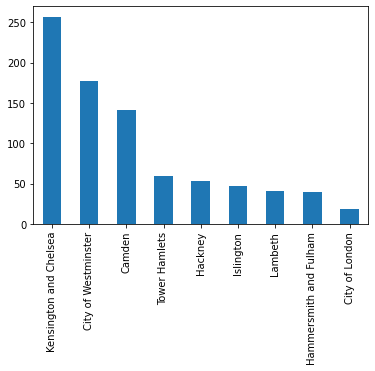

In [49]:
spotahome_eda['neighbourhood'].value_counts().plot(kind='bar');

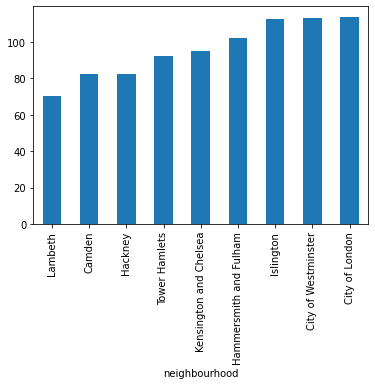

In [50]:
spotahome_eda.groupby('neighbourhood')['price_sqm'].mean().sort_values().plot(kind='bar');